In [1]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
from torch.utils.data import DataLoader
from src.model import LinearModel
from src.data import dataset
from src.runner import train, test
from src.viz import loss_visualize, acc_visualize

In [2]:
import wandb

sweep_config = {
    'method': 'grid'
    }

metric = {
    'name': 'val_acc',
    'goal': 'maximize'   
    }

sweep_config['metric'] = metric

parameters_dict = {
    'learning_rate': {
        'values': [0.001,0.0001,0.1]
        },
    'hidden_size': {
        'values': [[256,128], [256,256], [256,64], [512,256], [512,512], [1024,512],[1024,1024],[1024,256], [512,128],[2042,1024],[2042,512],[2042,256]]
        },
    'num_epochs': {
          'values': [3000]
        },
    'batch_size': {
          'values': [128]
        },
    }

sweep_config['parameters'] = parameters_dict

sweep_id = wandb.sweep(sweep_config, project="696ds_deepmind")

wandb.init(config=sweep_config,project="696ds_deepmind", entity="696ds_deepmind")

Create sweep with ID: lrjmlzv4
Sweep URL: https://wandb.ai/696ds_deepmind/696ds_deepmind/sweeps/lrjmlzv4


wandb: Currently logged in as: 696ds_deepmind (use `wandb login --relogin` to force relogin)


In [3]:
def run():
    wandb.init(config=sweep_config,project="696ds_deepmind", entity="696ds_deepmind")
    ######################### Hyper-parameters #########################
    config = wandb.config

    out_size = 1
    num_epochs = config.num_epochs #1500
    learning_rate = config.learning_rate #0.001
    hidden_size = config.hidden_size #[40,20]
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    batch_size = config.batch_size #128
    data_normal = pd.read_csv("data_normal.csv")
    num_clusters = data_normal.cluster.nunique()
    with_clusters = False

    if with_clusters:
        input_cols = ["x_1", "x_2", "cluster"]
        input_size = 3
    else:
        input_cols = ["x_1", "x_2"]
        input_size = 2

    X_train, X_test, y_train, y_test = train_test_split(np.array(data_normal[input_cols]), 
                           np.array(data_normal["y"]), test_size=0.3)


    trainset = dataset(torch.tensor(X_train,dtype=torch.float32).to(device), \
                        torch.tensor(y_train,dtype=torch.float32).to(device))
    testset = dataset(torch.tensor(X_test,dtype=torch.float32).to(device), \
                        torch.tensor(y_test,dtype=torch.float32).to(device))

    #DataLoader
    trainloader = DataLoader(trainset,batch_size=batch_size,shuffle=True)
    valloader = DataLoader(testset,batch_size=batch_size,shuffle=True)

    # model definition
    model = LinearModel(input_size, hidden_size, out_size, with_clusters = with_clusters, num_clusters = num_clusters).to(device)
    criterion = nn.BCEWithLogitsLoss()
    # criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model, tr_loss, tr_acc, val_acc = train(model, trainloader, valloader, \
                            optimizer, num_epochs, criterion)
    loss_visualize(tr_loss, "Loss vs iteration")
    acc_visualize([tr_acc, val_acc], \
                    ["training accuracy", "validation accuracy"], \
                    "Accuracy vs epochs")
    best_val_acc = max(val_acc)
    best_train_acc = max(tr_acc)
    wandb.log({"val_acc": best_val_acc})
    wandb.log({"train_acc":best_train_acc})
    wandb.log({"loss":tr_loss})
    print("Val_acc",best_val_acc)
    # wandb.log({"best_trn_acc": tr_acc}) 

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Agent Starting Run: 2pocgplu with config:
wandb: 	batch_size: 128
wandb: 	hidden_size: [256, 128]
wandb: 	learning_rate: 0.001
wandb: 	num_epochs: 3000
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


/opt/nidhi/assignments/696/696_experiments/src/data.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(x,dtype=torch.float32)
/opt/nidhi/assignments/696/696_experiments/src/data.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y,dtype=torch.float32)
  0%|                                                                                                                                                                             | 1/3000 [00:00<16:21,  3.06it/s]

Loss:  0.7027493811616994


  3%|█████▊                                                                                                                                                                     | 101/3000 [00:25<12:13,  3.95it/s]

Loss:  0.5335628673283741


  7%|███████████▍                                                                                                                                                               | 201/3000 [00:50<12:09,  3.84it/s]

Loss:  0.4824657744229442


 10%|█████████████████▏                                                                                                                                                         | 301/3000 [01:19<13:09,  3.42it/s]

Loss:  0.4647383418950168


 13%|██████████████████████▊                                                                                                                                                    | 401/3000 [01:49<13:23,  3.24it/s]

Loss:  0.44012966240295254


 17%|████████████████████████████▌                                                                                                                                              | 501/3000 [02:20<12:47,  3.26it/s]

Loss:  0.4330415834080089


 20%|██████████████████████████████████▎                                                                                                                                        | 601/3000 [02:57<16:30,  2.42it/s]

Loss:  0.4297602017118473


 23%|███████████████████████████████████████▉                                                                                                                                   | 701/3000 [03:32<16:56,  2.26it/s]

Loss:  0.41453906201352975


 27%|█████████████████████████████████████████████▋                                                                                                                             | 801/3000 [04:14<14:04,  2.60it/s]

Loss:  0.40369357845999976


 30%|███████████████████████████████████████████████████▎                                                                                                                       | 901/3000 [04:59<18:23,  1.90it/s]

Loss:  0.3988712764147556


 33%|████████████████████████████████████████████████████████▋                                                                                                                 | 1001/3000 [05:46<14:31,  2.29it/s]

Loss:  0.38873084356086424


 37%|██████████████████████████████████████████████████████████████▍                                                                                                           | 1101/3000 [06:37<12:22,  2.56it/s]

Loss:  0.38297819609593864


 40%|████████████████████████████████████████████████████████████████████                                                                                                      | 1201/3000 [07:24<16:24,  1.83it/s]

Loss:  0.3820535648952831


 43%|█████████████████████████████████████████████████████████████████████████▋                                                                                                | 1301/3000 [08:14<11:41,  2.42it/s]

Loss:  0.3678229842523132


 47%|███████████████████████████████████████████████████████████████████████████████▍                                                                                          | 1401/3000 [09:06<14:42,  1.81it/s]

Loss:  0.35442882053779834


 50%|█████████████████████████████████████████████████████████████████████████████████████                                                                                     | 1501/3000 [09:55<11:07,  2.25it/s]

Loss:  0.3481609458574141


 53%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 1601/3000 [10:51<12:59,  1.79it/s]

Loss:  0.337769479914145


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 1701/3000 [11:51<12:29,  1.73it/s]

Loss:  0.32874840287247087


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 1801/3000 [12:49<11:15,  1.77it/s]

Loss:  0.32493969030452496


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 1901/3000 [13:45<10:06,  1.81it/s]

Loss:  0.32298569561857166


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 2001/3000 [14:42<09:32,  1.74it/s]

Loss:  0.30936687838549565


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 2101/3000 [15:38<08:21,  1.79it/s]

Loss:  0.30884657980817737


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 2201/3000 [16:34<07:28,  1.78it/s]

Loss:  0.30801614893205237


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 2301/3000 [17:34<07:06,  1.64it/s]

Loss:  0.29413202088890655


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 2401/3000 [18:34<05:32,  1.80it/s]

Loss:  0.2819189096641059


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 2501/3000 [19:33<04:46,  1.74it/s]

Loss:  0.2848837872346242


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 2601/3000 [20:34<04:04,  1.63it/s]

Loss:  0.2836471398671468


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 2701/3000 [21:31<02:46,  1.79it/s]

Loss:  0.27070270012123415


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 2801/3000 [22:27<01:52,  1.77it/s]

Loss:  0.2849355194002691


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 2901/3000 [23:23<00:55,  1.79it/s]

Loss:  0.2785214688440766


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [24:19<00:00,  2.06it/s]


Val_acc 0.8824074074074074



train_acc,▁
val_acc,▁
train_acc,0.90143
val_acc,0.88241


wandb: Agent Starting Run: 00hswvlh with config:
wandb: 	batch_size: 128
wandb: 	hidden_size: [256, 128]
wandb: 	learning_rate: 0.0001
wandb: 	num_epochs: 3000
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


/opt/nidhi/assignments/696/696_experiments/src/data.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(x,dtype=torch.float32)
/opt/nidhi/assignments/696/696_experiments/src/data.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y,dtype=torch.float32)
  0%|                                                                                                                                                                             | 1/3000 [00:00<11:35,  4.31it/s]

Loss:  0.6879661691309226


  3%|█████▊                                                                                                                                                                     | 101/3000 [00:25<13:19,  3.63it/s]

Loss:  0.5954487137120179


  7%|███████████▍                                                                                                                                                               | 201/3000 [00:57<15:25,  3.02it/s]

Loss:  0.5562596673315222


 10%|█████████████████▏                                                                                                                                                         | 301/3000 [01:31<15:01,  2.99it/s]

Loss:  0.5310434644872492


 13%|██████████████████████▊                                                                                                                                                    | 401/3000 [02:04<14:32,  2.98it/s]

Loss:  0.5140539284306344


 17%|████████████████████████████▌                                                                                                                                              | 501/3000 [02:38<14:59,  2.78it/s]

Loss:  0.5007557778647451


 20%|██████████████████████████████████▎                                                                                                                                        | 601/3000 [03:12<13:30,  2.96it/s]

Loss:  0.4922200552742891


 23%|███████████████████████████████████████▉                                                                                                                                   | 701/3000 [03:46<13:06,  2.92it/s]

Loss:  0.48433156808217365


 27%|█████████████████████████████████████████████▋                                                                                                                             | 801/3000 [04:21<12:38,  2.90it/s]

Loss:  0.47688435876008234


 30%|███████████████████████████████████████████████████▎                                                                                                                       | 901/3000 [04:56<12:04,  2.90it/s]

Loss:  0.4780718810630567


 33%|████████████████████████████████████████████████████████▋                                                                                                                 | 1001/3000 [05:31<11:32,  2.89it/s]

Loss:  0.4646133310867078


 37%|██████████████████████████████████████████████████████████████▍                                                                                                           | 1101/3000 [06:07<11:38,  2.72it/s]

Loss:  0.46085373801414414


 40%|████████████████████████████████████████████████████████████████████                                                                                                      | 1201/3000 [06:42<10:44,  2.79it/s]

Loss:  0.46091713598280243


 43%|█████████████████████████████████████████████████████████████████████████▋                                                                                                | 1301/3000 [07:18<10:17,  2.75it/s]

Loss:  0.4514627568047456


 47%|███████████████████████████████████████████████████████████████████████████████▍                                                                                          | 1401/3000 [07:54<09:20,  2.85it/s]

Loss:  0.44884556802836334


 50%|█████████████████████████████████████████████████████████████████████████████████████                                                                                     | 1501/3000 [08:30<09:09,  2.73it/s]

Loss:  0.44631063125350257


 53%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 1601/3000 [09:14<09:11,  2.53it/s]

Loss:  0.44199451473024154


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 1701/3000 [09:56<08:35,  2.52it/s]

Loss:  0.4422609715750723


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 1800/3000 [10:33<08:59,  2.22it/s]

Loss:  0.43097245602896717


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 1901/3000 [11:11<06:35,  2.78it/s]

Loss:  0.42948662632643575


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 2001/3000 [11:47<06:05,  2.73it/s]

Loss:  0.42102350008608114


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 2101/3000 [12:24<05:20,  2.80it/s]

Loss:  0.41704840100172796


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 2201/3000 [13:00<04:48,  2.77it/s]

Loss:  0.41600908956142385


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 2301/3000 [13:36<04:12,  2.77it/s]

Loss:  0.4071430470606293


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 2401/3000 [14:13<03:44,  2.67it/s]

Loss:  0.40726806960924705


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 2501/3000 [14:49<03:04,  2.70it/s]

Loss:  0.40231586074588277


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 2601/3000 [15:26<02:25,  2.75it/s]

Loss:  0.4006667841564525


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 2701/3000 [16:06<01:53,  2.64it/s]

Loss:  0.38995475028500415


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 2801/3000 [16:43<01:13,  2.72it/s]

Loss:  0.387051401114223


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 2901/3000 [17:20<00:36,  2.73it/s]

Loss:  0.37972390170049186


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [18:03<00:00,  2.77it/s]


Val_acc 0.8344444444444444



train_acc,▁
val_acc,▁
train_acc,0.845
val_acc,0.83444


wandb: Agent Starting Run: tnuec8b5 with config:
wandb: 	batch_size: 128
wandb: 	hidden_size: [256, 128]
wandb: 	learning_rate: 0.1
wandb: 	num_epochs: 3000
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


/opt/nidhi/assignments/696/696_experiments/src/data.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(x,dtype=torch.float32)
/opt/nidhi/assignments/696/696_experiments/src/data.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y,dtype=torch.float32)
  0%|                                                                                                                                                                             | 1/3000 [00:00<13:20,  3.75it/s]

Loss:  5.402582781483429


  3%|█████▊                                                                                                                                                                     | 101/3000 [00:37<24:35,  1.96it/s]

Loss:  0.6938183927776838


  7%|███████████▍                                                                                                                                                               | 201/3000 [01:18<22:50,  2.04it/s]

Loss:  0.6936635712180474


 10%|█████████████████                                                                                                                                                          | 300/3000 [02:07<24:39,  1.82it/s]

Loss:  0.6934977215949936


 13%|██████████████████████▊                                                                                                                                                    | 401/3000 [02:56<16:46,  2.58it/s]

Loss:  0.6935375934899456


 17%|████████████████████████████▌                                                                                                                                              | 501/3000 [03:34<16:18,  2.55it/s]

Loss:  0.6937985642991885


 20%|██████████████████████████████████▎                                                                                                                                        | 601/3000 [04:15<17:04,  2.34it/s]

Loss:  0.6935181413033996


 23%|███████████████████████████████████████▉                                                                                                                                   | 701/3000 [04:59<16:43,  2.29it/s]

Loss:  0.6940511434969275


 27%|█████████████████████████████████████████████▋                                                                                                                             | 801/3000 [05:49<21:42,  1.69it/s]

Loss:  0.6939215979190788


 30%|███████████████████████████████████████████████████▎                                                                                                                       | 901/3000 [06:49<21:02,  1.66it/s]

Loss:  0.6938432027595212


 33%|████████████████████████████████████████████████████████▋                                                                                                                 | 1001/3000 [07:49<20:08,  1.65it/s]

Loss:  0.6937732491830383


 37%|██████████████████████████████████████████████████████████████▍                                                                                                           | 1101/3000 [08:48<18:50,  1.68it/s]

Loss:  0.6939970652262369


 40%|████████████████████████████████████████████████████████████████████                                                                                                      | 1201/3000 [09:48<18:30,  1.62it/s]

Loss:  0.6938818271714028


 43%|█████████████████████████████████████████████████████████████████████████▋                                                                                                | 1301/3000 [10:48<16:58,  1.67it/s]

Loss:  0.694027456370267


 47%|███████████████████████████████████████████████████████████████████████████████▍                                                                                          | 1401/3000 [11:48<16:08,  1.65it/s]

Loss:  0.6942865324742866


 50%|█████████████████████████████████████████████████████████████████████████████████████                                                                                     | 1501/3000 [12:48<15:15,  1.64it/s]

Loss:  0.6949706480960653


 53%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 1601/3000 [13:48<13:55,  1.67it/s]

Loss:  0.6946435612861557


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 1701/3000 [14:48<12:50,  1.69it/s]

Loss:  0.6940736138459408


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 1801/3000 [15:48<11:52,  1.68it/s]

Loss:  0.6934689060606137


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 1901/3000 [16:49<11:35,  1.58it/s]

Loss:  0.6938056741097961


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 2001/3000 [17:49<09:56,  1.68it/s]

Loss:  0.6935722532898488


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 2101/3000 [18:49<08:53,  1.69it/s]

Loss:  0.6936317989320466


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 2201/3000 [19:48<07:53,  1.69it/s]

Loss:  0.6957405769463741


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 2301/3000 [20:48<07:06,  1.64it/s]

Loss:  0.6939878162711558


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 2401/3000 [21:48<06:04,  1.64it/s]

Loss:  0.6937413805662983


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 2501/3000 [22:48<04:58,  1.67it/s]

Loss:  0.6941175256112609


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 2601/3000 [23:48<03:58,  1.67it/s]

Loss:  0.6944312471331973


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 2701/3000 [24:47<02:58,  1.67it/s]

Loss:  0.6944284264487449


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 2801/3000 [25:47<01:58,  1.67it/s]

Loss:  0.693628986676534


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 2901/3000 [26:47<00:58,  1.68it/s]

Loss:  0.6941491949437845


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [27:47<00:00,  1.80it/s]


Val_acc 0.5374074074074074



train_acc,▁
val_acc,▁
train_acc,0.53302
val_acc,0.53741


wandb: Agent Starting Run: zddcusyn with config:
wandb: 	batch_size: 128
wandb: 	hidden_size: [256, 256]
wandb: 	learning_rate: 0.001
wandb: 	num_epochs: 3000
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


/opt/nidhi/assignments/696/696_experiments/src/data.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(x,dtype=torch.float32)
/opt/nidhi/assignments/696/696_experiments/src/data.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y,dtype=torch.float32)
  0%|                                                                                                                                                                             | 1/3000 [00:00<13:10,  3.79it/s]

Loss:  0.7402423511851918


  3%|█████▊                                                                                                                                                                     | 101/3000 [00:30<16:30,  2.93it/s]

Loss:  0.5374380157451437


  7%|███████████▍                                                                                                                                                               | 201/3000 [01:11<18:54,  2.47it/s]

Loss:  0.49261909934005355


 10%|█████████████████▏                                                                                                                                                         | 301/3000 [01:52<18:23,  2.45it/s]

Loss:  0.4744232013972119


 13%|██████████████████████▊                                                                                                                                                    | 401/3000 [02:34<18:05,  2.39it/s]

Loss:  0.4524322001620977


 17%|████████████████████████████▌                                                                                                                                              | 501/3000 [03:16<17:56,  2.32it/s]

Loss:  0.43575256310328087


 20%|██████████████████████████████████▎                                                                                                                                        | 601/3000 [04:02<19:06,  2.09it/s]

Loss:  0.43967582360662594


 23%|███████████████████████████████████████▉                                                                                                                                   | 701/3000 [04:52<20:11,  1.90it/s]

Loss:  0.4164913489361002


 27%|█████████████████████████████████████████████▋                                                                                                                             | 801/3000 [05:53<24:37,  1.49it/s]

Loss:  0.41102485825317076


 30%|███████████████████████████████████████████████████▎                                                                                                                       | 901/3000 [07:02<24:44,  1.41it/s]

Loss:  0.4088637581979386


 33%|████████████████████████████████████████████████████████▋                                                                                                                 | 1001/3000 [08:14<23:52,  1.40it/s]

Loss:  0.4012192021114658


 37%|██████████████████████████████████████████████████████████████▍                                                                                                           | 1101/3000 [09:26<22:59,  1.38it/s]

Loss:  0.3910549854991412


 40%|████████████████████████████████████████████████████████████████████                                                                                                      | 1201/3000 [10:40<22:06,  1.36it/s]

Loss:  0.39235106471813086


 43%|█████████████████████████████████████████████████████████████████████████▋                                                                                                | 1301/3000 [11:53<20:52,  1.36it/s]

Loss:  0.38464009972533797


 47%|███████████████████████████████████████████████████████████████████████████████▍                                                                                          | 1401/3000 [13:07<19:38,  1.36it/s]

Loss:  0.3832731569054151


 50%|█████████████████████████████████████████████████████████████████████████████████████                                                                                     | 1501/3000 [14:22<18:29,  1.35it/s]

Loss:  0.37533029281731806


 53%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 1601/3000 [15:36<17:29,  1.33it/s]

Loss:  0.3761763900819451


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 1701/3000 [16:51<16:22,  1.32it/s]

Loss:  0.366182538295033


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 1801/3000 [18:06<14:55,  1.34it/s]

Loss:  0.37531552802432666


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 1901/3000 [19:22<13:47,  1.33it/s]

Loss:  0.3614645510008841


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 2001/3000 [20:37<12:30,  1.33it/s]

Loss:  0.3519676719049011


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 2101/3000 [21:53<11:19,  1.32it/s]

Loss:  0.35438224883994673


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 2201/3000 [23:08<10:00,  1.33it/s]

Loss:  0.3444378534049699


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 2301/3000 [24:24<08:47,  1.33it/s]

Loss:  0.34395256217079934


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 2401/3000 [25:40<07:36,  1.31it/s]

Loss:  0.3432882557613681


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 2501/3000 [27:00<06:33,  1.27it/s]

Loss:  0.3381575978163517


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 2601/3000 [28:23<05:41,  1.17it/s]

Loss:  0.3359321504831314


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 2700/3000 [29:44<04:21,  1.15it/s]

Loss:  0.3372011204259564


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 2801/3000 [31:04<02:32,  1.30it/s]

Loss:  0.33915223963934965


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 2901/3000 [32:21<01:16,  1.29it/s]

Loss:  0.33171049407636277


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [33:37<00:00,  1.49it/s]


Val_acc 0.8587037037037037



train_acc,▁
val_acc,▁
train_acc,0.87563
val_acc,0.8587


wandb: Agent Starting Run: hcacf0nx with config:
wandb: 	batch_size: 128
wandb: 	hidden_size: [256, 256]
wandb: 	learning_rate: 0.0001
wandb: 	num_epochs: 3000
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


/opt/nidhi/assignments/696/696_experiments/src/data.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(x,dtype=torch.float32)
/opt/nidhi/assignments/696/696_experiments/src/data.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y,dtype=torch.float32)
  0%|                                                                                                                                                                             | 1/3000 [00:00<13:51,  3.61it/s]

Loss:  0.6875152750448748


  3%|█████▊                                                                                                                                                                     | 101/3000 [00:30<18:14,  2.65it/s]

Loss:  0.5859738485981719


  7%|███████████▍                                                                                                                                                               | 201/3000 [01:06<16:59,  2.75it/s]

Loss:  0.542769160836634


 10%|█████████████████▏                                                                                                                                                         | 301/3000 [01:44<16:27,  2.73it/s]

Loss:  0.5246231926209999


 13%|██████████████████████▊                                                                                                                                                    | 401/3000 [02:21<15:56,  2.72it/s]

Loss:  0.5054311830588062


 17%|████████████████████████████▌                                                                                                                                              | 501/3000 [02:58<15:49,  2.63it/s]

Loss:  0.4937589340137713


 20%|██████████████████████████████████▎                                                                                                                                        | 601/3000 [03:37<15:19,  2.61it/s]

Loss:  0.4812750084833665


 23%|███████████████████████████████████████▉                                                                                                                                   | 701/3000 [04:16<15:00,  2.55it/s]

Loss:  0.47591740344509936


 27%|█████████████████████████████████████████████▋                                                                                                                             | 801/3000 [04:55<14:45,  2.48it/s]

Loss:  0.46497986864561985


 30%|███████████████████████████████████████████████████▎                                                                                                                       | 901/3000 [05:36<14:09,  2.47it/s]

Loss:  0.458923155310178


 33%|████████████████████████████████████████████████████████▋                                                                                                                 | 1001/3000 [06:17<13:43,  2.43it/s]

Loss:  0.45669113084523366


 37%|██████████████████████████████████████████████████████████████▍                                                                                                           | 1101/3000 [06:59<13:28,  2.35it/s]

Loss:  0.4485406354822294


 40%|████████████████████████████████████████████████████████████████████                                                                                                      | 1201/3000 [07:42<12:57,  2.31it/s]

Loss:  0.44259429459620003


 43%|█████████████████████████████████████████████████████████████████████████▋                                                                                                | 1301/3000 [08:25<12:15,  2.31it/s]

Loss:  0.4336606303248743


 47%|███████████████████████████████████████████████████████████████████████████████▍                                                                                          | 1401/3000 [09:09<11:52,  2.24it/s]

Loss:  0.4317324128415849


 50%|█████████████████████████████████████████████████████████████████████████████████████                                                                                     | 1501/3000 [09:54<11:12,  2.23it/s]

Loss:  0.4180709749761254


 53%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 1601/3000 [10:39<10:32,  2.21it/s]

Loss:  0.4181082486504256


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 1701/3000 [11:24<09:47,  2.21it/s]

Loss:  0.4085922957670809


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 1801/3000 [12:11<09:16,  2.16it/s]

Loss:  0.3979414204756419


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 1900/3000 [12:57<08:49,  2.08it/s]

Loss:  0.3970135043967854


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 2001/3000 [13:46<08:05,  2.06it/s]

Loss:  0.39232857811330546


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 2101/3000 [14:34<07:15,  2.06it/s]

Loss:  0.3839674947237728


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 2201/3000 [15:22<06:26,  2.07it/s]

Loss:  0.37798651360502145


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 2301/3000 [16:10<05:40,  2.05it/s]

Loss:  0.37243097960346877


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 2401/3000 [16:58<04:50,  2.06it/s]

Loss:  0.3672119749314857


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 2501/3000 [17:47<04:12,  1.97it/s]

Loss:  0.3577228278824777


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 2601/3000 [18:37<03:26,  1.94it/s]

Loss:  0.35594438166931425


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 2701/3000 [19:29<02:32,  1.96it/s]

Loss:  0.3505876669377992


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 2801/3000 [20:18<01:38,  2.02it/s]

Loss:  0.3448482027860603


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 2901/3000 [21:08<00:50,  1.95it/s]

Loss:  0.3416774117886418


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [21:58<00:00,  2.27it/s]


Val_acc 0.8462962962962963



train_acc,▁
val_acc,▁
train_acc,0.86429
val_acc,0.8463


wandb: Agent Starting Run: resh7ymr with config:
wandb: 	batch_size: 128
wandb: 	hidden_size: [256, 256]
wandb: 	learning_rate: 0.1
wandb: 	num_epochs: 3000
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


/opt/nidhi/assignments/696/696_experiments/src/data.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(x,dtype=torch.float32)
/opt/nidhi/assignments/696/696_experiments/src/data.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y,dtype=torch.float32)
  0%|                                                                                                                                                                             | 1/3000 [00:00<13:33,  3.69it/s]

Loss:  9.53494613459616


  3%|█████▊                                                                                                                                                                     | 101/3000 [00:33<19:53,  2.43it/s]

Loss:  0.6920761935638658


  7%|███████████▍                                                                                                                                                               | 201/3000 [01:14<19:22,  2.41it/s]

Loss:  0.6944696867104733


 10%|█████████████████▏                                                                                                                                                         | 301/3000 [01:56<18:33,  2.42it/s]

Loss:  0.694004931233146


 13%|██████████████████████▊                                                                                                                                                    | 401/3000 [02:37<17:53,  2.42it/s]

Loss:  0.6936120132003167


 17%|████████████████████████████▌                                                                                                                                              | 501/3000 [03:19<17:23,  2.39it/s]

Loss:  0.694063304048596


 20%|██████████████████████████████████▎                                                                                                                                        | 601/3000 [04:05<20:12,  1.98it/s]

Loss:  0.6945237691956337


 23%|███████████████████████████████████████▉                                                                                                                                   | 701/3000 [04:56<20:39,  1.85it/s]

Loss:  0.6947187239473517


 27%|█████████████████████████████████████████████▋                                                                                                                             | 801/3000 [06:02<30:00,  1.22it/s]

Loss:  0.6954444664897341


 30%|███████████████████████████████████████████████████▎                                                                                                                       | 901/3000 [07:25<29:06,  1.20it/s]

Loss:  0.6937886524682093


 33%|████████████████████████████████████████████████████████▋                                                                                                                 | 1001/3000 [08:48<27:29,  1.21it/s]

Loss:  0.6939630586691578


 37%|██████████████████████████████████████████████████████████████▍                                                                                                           | 1101/3000 [10:11<26:12,  1.21it/s]

Loss:  0.6941480341583791


 40%|████████████████████████████████████████████████████████████████████                                                                                                      | 1201/3000 [11:34<24:46,  1.21it/s]

Loss:  0.6952514010246353


 43%|█████████████████████████████████████████████████████████████████████████▋                                                                                                | 1301/3000 [12:58<23:37,  1.20it/s]

Loss:  0.6937533532730257


 47%|███████████████████████████████████████████████████████████████████████████████▍                                                                                          | 1401/3000 [14:21<22:03,  1.21it/s]

Loss:  0.6937426172121607


 50%|█████████████████████████████████████████████████████████████████████████████████████                                                                                     | 1501/3000 [15:44<20:36,  1.21it/s]

Loss:  0.6936057595291523


 53%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 1601/3000 [17:07<19:16,  1.21it/s]

Loss:  0.6943038623742382


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 1701/3000 [18:30<17:53,  1.21it/s]

Loss:  0.6935715717498703


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 1801/3000 [19:53<16:36,  1.20it/s]

Loss:  0.6944839532929238


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 1901/3000 [21:16<15:14,  1.20it/s]

Loss:  0.6936087740792168


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 2001/3000 [22:39<13:43,  1.21it/s]

Loss:  0.6937566544070388


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 2101/3000 [24:02<12:29,  1.20it/s]

Loss:  0.6949618235983029


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 2201/3000 [25:25<11:18,  1.18it/s]

Loss:  0.6943602453578602


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 2301/3000 [26:49<09:46,  1.19it/s]

Loss:  0.6942684271118857


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 2401/3000 [28:12<08:16,  1.21it/s]

Loss:  0.694079562871143


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 2501/3000 [29:35<06:56,  1.20it/s]

Loss:  0.6939602801294038


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 2601/3000 [30:58<05:29,  1.21it/s]

Loss:  0.6944244720719077


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 2701/3000 [32:21<04:06,  1.21it/s]

Loss:  0.6949165668150391


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 2801/3000 [33:44<02:44,  1.21it/s]

Loss:  0.6944695927880027


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 2901/3000 [35:07<01:22,  1.21it/s]

Loss:  0.6938980679319362


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [36:29<00:00,  1.37it/s]


Val_acc 0.5214814814814814



train_acc,▁
val_acc,▁
train_acc,0.51714
val_acc,0.52148


wandb: Agent Starting Run: 3dru89u7 with config:
wandb: 	batch_size: 128
wandb: 	hidden_size: [256, 64]
wandb: 	learning_rate: 0.001
wandb: 	num_epochs: 3000
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


/opt/nidhi/assignments/696/696_experiments/src/data.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(x,dtype=torch.float32)
/opt/nidhi/assignments/696/696_experiments/src/data.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y,dtype=torch.float32)
  0%|                                                                                                                                                                             | 1/3000 [00:00<11:01,  4.53it/s]

Loss:  0.7121007845859335


  3%|█████▊                                                                                                                                                                     | 101/3000 [00:24<13:16,  3.64it/s]

Loss:  0.5445383486121592


  7%|███████████▍                                                                                                                                                               | 201/3000 [00:57<15:25,  3.02it/s]

Loss:  0.5160058784966517


 10%|█████████████████▏                                                                                                                                                         | 301/3000 [01:30<14:46,  3.05it/s]

Loss:  0.49301879725070913


 13%|██████████████████████▊                                                                                                                                                    | 401/3000 [01:59<12:05,  3.58it/s]

Loss:  0.47901492919584715


 17%|████████████████████████████▌                                                                                                                                              | 501/3000 [02:32<13:53,  3.00it/s]

Loss:  0.47798134762831407


 20%|██████████████████████████████████▎                                                                                                                                        | 601/3000 [03:06<14:01,  2.85it/s]

Loss:  0.47560520545400753


 23%|███████████████████████████████████████▉                                                                                                                                   | 701/3000 [03:42<13:38,  2.81it/s]

Loss:  0.4699903696474403


 27%|█████████████████████████████████████████████▋                                                                                                                             | 801/3000 [04:20<15:10,  2.42it/s]

Loss:  0.45520705255595123


 30%|███████████████████████████████████████████████████▎                                                                                                                       | 901/3000 [05:01<14:24,  2.43it/s]

Loss:  0.4516293231887047


 33%|████████████████████████████████████████████████████████▋                                                                                                                 | 1001/3000 [05:42<13:38,  2.44it/s]

Loss:  0.4536245856622253


 37%|██████████████████████████████████████████████████████████████▍                                                                                                           | 1101/3000 [06:23<12:56,  2.44it/s]

Loss:  0.44616476062572363


 40%|████████████████████████████████████████████████████████████████████                                                                                                      | 1201/3000 [07:05<12:31,  2.39it/s]

Loss:  0.44345980641817806


 43%|█████████████████████████████████████████████████████████████████████████▋                                                                                                | 1301/3000 [07:46<11:58,  2.37it/s]

Loss:  0.44316594076879096


 47%|███████████████████████████████████████████████████████████████████████████████▍                                                                                          | 1401/3000 [08:28<11:08,  2.39it/s]

Loss:  0.43006138036949465


 50%|█████████████████████████████████████████████████████████████████████████████████████                                                                                     | 1501/3000 [09:10<10:26,  2.39it/s]

Loss:  0.4209000155179187


 53%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 1601/3000 [09:52<09:38,  2.42it/s]

Loss:  0.4170824382642303


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 1701/3000 [10:34<09:04,  2.39it/s]

Loss:  0.4123065953302865


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 1801/3000 [11:16<08:30,  2.35it/s]

Loss:  0.4082288043667572


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 1901/3000 [11:57<07:42,  2.37it/s]

Loss:  0.40234149917207584


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 2001/3000 [12:40<07:02,  2.36it/s]

Loss:  0.4071841279063562


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 2101/3000 [13:22<06:21,  2.36it/s]

Loss:  0.3991059134102831


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 2201/3000 [14:05<05:34,  2.39it/s]

Loss:  0.3901905589031451


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 2301/3000 [14:47<04:56,  2.35it/s]

Loss:  0.39213794620350156


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 2401/3000 [15:30<04:21,  2.29it/s]

Loss:  0.3834295892956281


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 2501/3000 [16:12<03:29,  2.38it/s]

Loss:  0.37820095666731246


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 2601/3000 [16:55<02:48,  2.37it/s]

Loss:  0.38053968879911637


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 2701/3000 [17:37<02:07,  2.35it/s]

Loss:  0.3832769613675397


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 2801/3000 [18:20<01:25,  2.32it/s]

Loss:  0.38102521589308075


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 2901/3000 [19:03<00:42,  2.34it/s]

Loss:  0.3772039594072284


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [19:45<00:00,  2.53it/s]


Val_acc 0.8387037037037037



train_acc,▁
val_acc,▁
train_acc,0.8531
val_acc,0.8387


wandb: Agent Starting Run: t49rr9oq with config:
wandb: 	batch_size: 128
wandb: 	hidden_size: [256, 64]
wandb: 	learning_rate: 0.0001
wandb: 	num_epochs: 3000
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


/opt/nidhi/assignments/696/696_experiments/src/data.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(x,dtype=torch.float32)
/opt/nidhi/assignments/696/696_experiments/src/data.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y,dtype=torch.float32)
  0%|                                                                                                                                                                             | 1/3000 [00:00<13:03,  3.83it/s]

Loss:  0.6892323626412286


  3%|█████▊                                                                                                                                                                     | 101/3000 [00:23<12:45,  3.79it/s]

Loss:  0.6093829996658094


  7%|███████████▍                                                                                                                                                               | 201/3000 [00:54<14:30,  3.21it/s]

Loss:  0.5746188199881351


 10%|█████████████████▏                                                                                                                                                         | 301/3000 [01:26<14:22,  3.13it/s]

Loss:  0.5493494510048568


 13%|██████████████████████▊                                                                                                                                                    | 401/3000 [01:57<13:36,  3.18it/s]

Loss:  0.5385958892528457


 17%|████████████████████████████▌                                                                                                                                              | 501/3000 [02:29<13:15,  3.14it/s]

Loss:  0.5242078677572385


 20%|██████████████████████████████████▎                                                                                                                                        | 601/3000 [03:00<12:47,  3.13it/s]

Loss:  0.5153184924462829


 23%|███████████████████████████████████████▉                                                                                                                                   | 701/3000 [03:33<12:13,  3.13it/s]

Loss:  0.5026027722792192


 27%|█████████████████████████████████████████████▋                                                                                                                             | 801/3000 [04:07<11:32,  3.17it/s]

Loss:  0.49795441735874524


 30%|███████████████████████████████████████████████████▎                                                                                                                       | 901/3000 [04:40<11:35,  3.02it/s]

Loss:  0.4905518055564225


 33%|████████████████████████████████████████████████████████▋                                                                                                                 | 1001/3000 [05:12<10:35,  3.14it/s]

Loss:  0.48823987353931775


 37%|██████████████████████████████████████████████████████████████▍                                                                                                           | 1101/3000 [05:44<10:18,  3.07it/s]

Loss:  0.4819815360536479


 40%|████████████████████████████████████████████████████████████████████                                                                                                      | 1201/3000 [06:17<09:39,  3.10it/s]

Loss:  0.4777704227452326


 43%|█████████████████████████████████████████████████████████████████████████▋                                                                                                | 1301/3000 [06:49<09:02,  3.13it/s]

Loss:  0.47316281693150297


 47%|███████████████████████████████████████████████████████████████████████████████▍                                                                                          | 1401/3000 [07:22<08:41,  3.07it/s]

Loss:  0.47423238886727226


 50%|█████████████████████████████████████████████████████████████████████████████████████                                                                                     | 1501/3000 [07:54<08:08,  3.07it/s]

Loss:  0.46874123480584884


 53%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 1601/3000 [08:27<07:36,  3.06it/s]

Loss:  0.4622898454015905


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 1701/3000 [08:59<06:59,  3.09it/s]

Loss:  0.45908897543194316


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 1801/3000 [09:32<06:26,  3.10it/s]

Loss:  0.45910186719412754


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 1901/3000 [10:04<05:56,  3.08it/s]

Loss:  0.45659853683577645


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 2001/3000 [10:37<05:26,  3.06it/s]

Loss:  0.45760810134386776


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 2101/3000 [11:09<04:50,  3.10it/s]

Loss:  0.4542376531494988


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 2201/3000 [11:42<04:20,  3.06it/s]

Loss:  0.4567323456508945


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 2301/3000 [12:14<03:54,  2.98it/s]

Loss:  0.44895389766404126


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 2401/3000 [12:47<03:13,  3.09it/s]

Loss:  0.4503651574404553


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 2501/3000 [13:20<02:45,  3.02it/s]

Loss:  0.4544421509660856


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 2601/3000 [13:52<02:09,  3.08it/s]

Loss:  0.4507054216933973


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 2701/3000 [14:25<01:37,  3.07it/s]

Loss:  0.4519414651875544


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 2801/3000 [14:58<01:04,  3.10it/s]

Loss:  0.44584520958890816


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 2901/3000 [15:30<00:32,  3.07it/s]

Loss:  0.44454033025587447


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [16:03<00:00,  3.11it/s]


Val_acc 0.805



train_acc,▁
val_acc,▁
train_acc,0.81762
val_acc,0.805


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6b9e5pz1 with config:
wandb: 	batch_size: 128
wandb: 	hidden_size: [256, 64]
wandb: 	learning_rate: 0.1
wandb: 	num_epochs: 3000
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


/opt/nidhi/assignments/696/696_experiments/src/data.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(x,dtype=torch.float32)
/opt/nidhi/assignments/696/696_experiments/src/data.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y,dtype=torch.float32)
  0%|                                                                                                                                                                             | 1/3000 [00:00<12:45,  3.92it/s]

Loss:  2.5366773220023724


  3%|█████▊                                                                                                                                                                     | 101/3000 [00:25<13:27,  3.59it/s]

Loss:  0.6901699244373977


  7%|███████████▍                                                                                                                                                               | 201/3000 [00:59<15:52,  2.94it/s]

Loss:  0.6906380280099734


 10%|█████████████████▏                                                                                                                                                         | 301/3000 [01:33<15:42,  2.86it/s]

Loss:  0.6931530484045395


 13%|██████████████████████▊                                                                                                                                                    | 401/3000 [02:07<14:46,  2.93it/s]

Loss:  0.6928852019887982


 17%|████████████████████████████▌                                                                                                                                              | 501/3000 [02:41<14:22,  2.90it/s]

Loss:  0.6937520154798874


 20%|██████████████████████████████████▎                                                                                                                                        | 601/3000 [03:16<14:33,  2.75it/s]

Loss:  0.6932808774890322


 23%|███████████████████████████████████████▉                                                                                                                                   | 701/3000 [03:53<14:05,  2.72it/s]

Loss:  0.6926476527946164


 27%|█████████████████████████████████████████████▋                                                                                                                             | 801/3000 [04:34<16:30,  2.22it/s]

Loss:  0.6930562161435985


 30%|███████████████████████████████████████████████████▎                                                                                                                       | 901/3000 [05:19<15:50,  2.21it/s]

Loss:  0.6938077193317991


 33%|████████████████████████████████████████████████████████▋                                                                                                                 | 1001/3000 [06:05<16:29,  2.02it/s]

Loss:  0.6932025052080251


 37%|██████████████████████████████████████████████████████████████▍                                                                                                           | 1101/3000 [06:50<14:17,  2.22it/s]

Loss:  0.6928964347550364


 40%|████████████████████████████████████████████████████████████████████                                                                                                      | 1201/3000 [07:35<13:59,  2.14it/s]

Loss:  0.6933677238647384


 43%|█████████████████████████████████████████████████████████████████████████▋                                                                                                | 1301/3000 [08:21<12:48,  2.21it/s]

Loss:  0.6936955692792179


 47%|███████████████████████████████████████████████████████████████████████████████▍                                                                                          | 1401/3000 [09:06<12:10,  2.19it/s]

Loss:  0.6930898012536945


 50%|█████████████████████████████████████████████████████████████████████████████████████                                                                                     | 1501/3000 [09:52<11:10,  2.24it/s]

Loss:  0.6933737818640892


 53%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 1601/3000 [10:37<10:36,  2.20it/s]

Loss:  0.6928531888759497


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 1701/3000 [11:22<09:43,  2.23it/s]

Loss:  0.6930571692158477


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 1801/3000 [12:08<09:10,  2.18it/s]

Loss:  0.6932975734123076


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 1901/3000 [12:53<08:20,  2.20it/s]

Loss:  0.693712116491915


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 2001/3000 [13:38<07:37,  2.19it/s]

Loss:  0.694163340510744


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 2101/3000 [14:23<06:54,  2.17it/s]

Loss:  0.6932011607921484


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 2201/3000 [15:09<06:01,  2.21it/s]

Loss:  0.6935521833824388


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 2301/3000 [15:54<05:14,  2.22it/s]

Loss:  0.6933720575438606


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 2401/3000 [16:39<04:30,  2.22it/s]

Loss:  0.69260655930548


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 2501/3000 [17:20<02:55,  2.85it/s]

Loss:  0.6928405394457807


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 2601/3000 [18:02<02:59,  2.22it/s]

Loss:  0.6928867167896695


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 2701/3000 [18:47<02:14,  2.22it/s]

Loss:  0.6940930148567817


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 2801/3000 [19:25<01:13,  2.71it/s]

Loss:  0.6931349117346485


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 2901/3000 [20:08<00:44,  2.23it/s]

Loss:  0.6939173160177289


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [20:53<00:00,  2.39it/s]


Val_acc 0.5153703703703704



train_acc,▁
val_acc,▁
train_acc,0.51286
val_acc,0.51537


wandb: Agent Starting Run: xqglujle with config:
wandb: 	batch_size: 128
wandb: 	hidden_size: [512, 256]
wandb: 	learning_rate: 0.001
wandb: 	num_epochs: 3000
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


/opt/nidhi/assignments/696/696_experiments/src/data.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(x,dtype=torch.float32)
/opt/nidhi/assignments/696/696_experiments/src/data.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y,dtype=torch.float32)
  0%|                                                                                                                                                                             | 1/3000 [00:00<17:58,  2.78it/s]

Loss:  0.7541332455596539


  3%|█████▊                                                                                                                                                                     | 101/3000 [00:41<23:27,  2.06it/s]

Loss:  0.5487616637138405


  7%|███████████▍                                                                                                                                                               | 201/3000 [01:30<22:52,  2.04it/s]

Loss:  0.5102371636665228


 10%|█████████████████▏                                                                                                                                                         | 301/3000 [02:19<21:46,  2.07it/s]

Loss:  0.49115358759658506


 13%|██████████████████████▊                                                                                                                                                    | 401/3000 [03:09<21:10,  2.05it/s]

Loss:  0.4718594228980517


 17%|████████████████████████████▌                                                                                                                                              | 501/3000 [04:00<23:18,  1.79it/s]

Loss:  0.460919441899868


 20%|██████████████████████████████████▎                                                                                                                                        | 601/3000 [05:01<26:48,  1.49it/s]

Loss:  0.45976991725690436


 23%|███████████████████████████████████████▉                                                                                                                                   | 701/3000 [06:12<29:30,  1.30it/s]

Loss:  0.4462432689738996


 27%|█████████████████████████████████████████████▋                                                                                                                             | 801/3000 [07:47<40:04,  1.09s/it]

Loss:  0.44719890873841567


 30%|███████████████████████████████████████████████████▎                                                                                                                       | 901/3000 [09:37<38:32,  1.10s/it]

Loss:  0.4435041032054208


 33%|████████████████████████████████████████████████████████▋                                                                                                                 | 1001/3000 [11:29<37:34,  1.13s/it]

Loss:  0.4305446214146084


 37%|██████████████████████████████████████████████████████████████▍                                                                                                           | 1101/3000 [13:22<35:52,  1.13s/it]

Loss:  0.4243449860751027


 40%|████████████████████████████████████████████████████████████████████                                                                                                      | 1201/3000 [15:17<34:38,  1.16s/it]

Loss:  0.412594350901517


 43%|█████████████████████████████████████████████████████████████████████████▋                                                                                                | 1301/3000 [17:13<33:12,  1.17s/it]

Loss:  0.40427408856574937


 47%|███████████████████████████████████████████████████████████████████████████████▍                                                                                          | 1401/3000 [19:11<31:18,  1.18s/it]

Loss:  0.39652198884222245


 50%|█████████████████████████████████████████████████████████████████████████████████████                                                                                     | 1501/3000 [21:09<29:38,  1.19s/it]

Loss:  0.3913262501509503


 53%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 1601/3000 [23:08<27:58,  1.20s/it]

Loss:  0.384656085209413


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 1701/3000 [25:08<26:00,  1.20s/it]

Loss:  0.37803964060966416


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 1801/3000 [27:08<24:19,  1.22s/it]

Loss:  0.37290905431063487


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 1901/3000 [29:09<22:29,  1.23s/it]

Loss:  0.36258381003081197


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 2001/3000 [31:09<20:17,  1.22s/it]

Loss:  0.36644088920920787


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 2101/3000 [33:09<18:29,  1.23s/it]

Loss:  0.3619459614609227


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 2201/3000 [35:10<16:22,  1.23s/it]

Loss:  0.3571104836283308


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 2301/3000 [37:10<14:13,  1.22s/it]

Loss:  0.3559479894060077


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 2401/3000 [39:11<12:22,  1.24s/it]

Loss:  0.3455070647025349


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 2501/3000 [41:11<10:05,  1.21s/it]

Loss:  0.3481898142231835


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 2601/3000 [43:11<07:58,  1.20s/it]

Loss:  0.35694919391111896


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 2701/3000 [45:12<06:01,  1.21s/it]

Loss:  0.33260462229902094


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 2800/3000 [47:12<04:01,  1.21s/it]

Loss:  0.33269813656806946


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 2901/3000 [49:14<01:59,  1.20s/it]

Loss:  0.32941754357983366


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [51:14<00:00,  1.02s/it]


Val_acc 0.8640740740740741



train_acc,▁
val_acc,▁
train_acc,0.87571
val_acc,0.86407


wandb: Agent Starting Run: t87ndtse with config:
wandb: 	batch_size: 128
wandb: 	hidden_size: [512, 256]
wandb: 	learning_rate: 0.0001
wandb: 	num_epochs: 3000
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


/opt/nidhi/assignments/696/696_experiments/src/data.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(x,dtype=torch.float32)
/opt/nidhi/assignments/696/696_experiments/src/data.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y,dtype=torch.float32)
  0%|                                                                                                                                                                             | 1/3000 [00:00<19:28,  2.57it/s]

Loss:  0.6960501183163036


  3%|█████▊                                                                                                                                                                     | 101/3000 [00:40<21:45,  2.22it/s]

Loss:  0.5702339925549247


  7%|███████████▍                                                                                                                                                               | 201/3000 [01:25<20:57,  2.23it/s]

Loss:  0.5330684717857477


 10%|█████████████████▏                                                                                                                                                         | 301/3000 [02:10<20:27,  2.20it/s]

Loss:  0.5129623991070371


 13%|██████████████████████▊                                                                                                                                                    | 401/3000 [02:56<20:19,  2.13it/s]

Loss:  0.4913143720289673


 17%|████████████████████████████▌                                                                                                                                              | 501/3000 [03:43<20:03,  2.08it/s]

Loss:  0.4894284756496699


 20%|██████████████████████████████████▎                                                                                                                                        | 601/3000 [04:33<19:53,  2.01it/s]

Loss:  0.4718889934245986


 23%|███████████████████████████████████████▉                                                                                                                                   | 701/3000 [05:24<20:05,  1.91it/s]

Loss:  0.4605188315564936


 27%|█████████████████████████████████████████████▋                                                                                                                             | 801/3000 [06:19<20:35,  1.78it/s]

Loss:  0.4544544021288554


 30%|███████████████████████████████████████████████████▎                                                                                                                       | 901/3000 [07:16<20:24,  1.71it/s]

Loss:  0.4449949791335096


 33%|████████████████████████████████████████████████████████▋                                                                                                                 | 1001/3000 [08:16<21:07,  1.58it/s]

Loss:  0.4385255846110257


 37%|██████████████████████████████████████████████████████████████▍                                                                                                           | 1101/3000 [09:20<20:39,  1.53it/s]

Loss:  0.42991978772962935


 40%|████████████████████████████████████████████████████████████████████                                                                                                      | 1201/3000 [10:26<19:52,  1.51it/s]

Loss:  0.4228475364771756


 43%|█████████████████████████████████████████████████████████████████████████▋                                                                                                | 1301/3000 [11:34<19:35,  1.45it/s]

Loss:  0.4179487198290199


 47%|███████████████████████████████████████████████████████████████████████████████▍                                                                                          | 1401/3000 [12:44<18:50,  1.42it/s]

Loss:  0.4068883353411549


 50%|█████████████████████████████████████████████████████████████████████████████████████                                                                                     | 1501/3000 [13:56<18:05,  1.38it/s]

Loss:  0.40239972719038375


 53%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 1601/3000 [15:10<17:02,  1.37it/s]

Loss:  0.4007030662262078


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 1701/3000 [16:23<15:54,  1.36it/s]

Loss:  0.40183435275097085


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 1801/3000 [17:38<14:46,  1.35it/s]

Loss:  0.39652452595306165


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 1901/3000 [18:52<13:30,  1.36it/s]

Loss:  0.3898584439296915


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 2001/3000 [20:07<12:33,  1.33it/s]

Loss:  0.38681545492374536


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 2101/3000 [21:22<11:19,  1.32it/s]

Loss:  0.38445643252796596


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 2201/3000 [22:39<10:10,  1.31it/s]

Loss:  0.37928255459274907


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 2301/3000 [23:56<09:03,  1.29it/s]

Loss:  0.3760054620227428


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 2401/3000 [25:13<07:42,  1.30it/s]

Loss:  0.37350450380884037


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 2501/3000 [26:30<06:24,  1.30it/s]

Loss:  0.36215779155191746


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 2601/3000 [27:49<05:12,  1.28it/s]

Loss:  0.3542722857961751


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 2701/3000 [29:07<03:57,  1.26it/s]

Loss:  0.35202762815687394


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 2801/3000 [30:26<02:37,  1.27it/s]

Loss:  0.3483532003381036


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 2901/3000 [31:46<01:19,  1.25it/s]

Loss:  0.3447167638576392


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [33:06<00:00,  1.51it/s]


Val_acc 0.847037037037037



train_acc,▁
val_acc,▁
train_acc,0.86603
val_acc,0.84704


wandb: Agent Starting Run: wy1zht4b with config:
wandb: 	batch_size: 128
wandb: 	hidden_size: [512, 256]
wandb: 	learning_rate: 0.1
wandb: 	num_epochs: 3000
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


/opt/nidhi/assignments/696/696_experiments/src/data.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(x,dtype=torch.float32)
/opt/nidhi/assignments/696/696_experiments/src/data.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y,dtype=torch.float32)
  0%|                                                                                                                                                                             | 1/3000 [00:00<16:31,  3.03it/s]

Loss:  23.809828815436124


  3%|█████▊                                                                                                                                                                     | 101/3000 [00:44<23:25,  2.06it/s]

Loss:  0.6871730408283195


  7%|███████████▍                                                                                                                                                               | 201/3000 [01:33<22:32,  2.07it/s]

Loss:  0.690072056018945


 10%|█████████████████▏                                                                                                                                                         | 301/3000 [02:22<21:59,  2.05it/s]

Loss:  0.6936425440239183


 13%|██████████████████████▊                                                                                                                                                    | 401/3000 [03:11<20:55,  2.07it/s]

Loss:  0.6939789050757282


 17%|████████████████████████████▌                                                                                                                                              | 501/3000 [04:00<20:58,  1.99it/s]

Loss:  0.693971538784528


 20%|██████████████████████████████████▎                                                                                                                                        | 601/3000 [04:58<26:44,  1.50it/s]

Loss:  0.6946636655113914


 23%|███████████████████████████████████████▉                                                                                                                                   | 701/3000 [06:07<27:14,  1.41it/s]

Loss:  0.6935252866359672


 27%|█████████████████████████████████████████████▋                                                                                                                             | 801/3000 [07:41<46:21,  1.26s/it]

Loss:  0.6936273683201183


 30%|███████████████████████████████████████████████████▎                                                                                                                       | 901/3000 [09:49<44:49,  1.28s/it]

Loss:  0.6941550903850131


 33%|████████████████████████████████████████████████████████▋                                                                                                                 | 1001/3000 [11:57<42:41,  1.28s/it]

Loss:  0.6939290472955415


 37%|██████████████████████████████████████████████████████████████▍                                                                                                           | 1101/3000 [14:02<31:26,  1.01it/s]

Loss:  0.6940427536916252


 40%|████████████████████████████████████████████████████████████████████                                                                                                      | 1201/3000 [16:01<29:26,  1.02it/s]

Loss:  0.6940558149357035


 43%|█████████████████████████████████████████████████████████████████████████▋                                                                                                | 1301/3000 [18:07<36:16,  1.28s/it]

Loss:  0.69405827739022


 47%|███████████████████████████████████████████████████████████████████████████████▍                                                                                          | 1401/3000 [20:16<34:04,  1.28s/it]

Loss:  0.6937680984988357


 50%|█████████████████████████████████████████████████████████████████████████████████████                                                                                     | 1501/3000 [22:25<32:09,  1.29s/it]

Loss:  0.6941647204485807


 53%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 1601/3000 [24:27<29:45,  1.28s/it]

Loss:  0.6937427129408326


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 1701/3000 [26:28<23:18,  1.08s/it]

Loss:  0.6937684982714026


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 1801/3000 [28:29<25:42,  1.29s/it]

Loss:  0.6939777768019474


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 1900/3000 [30:46<29:04,  1.59s/it]

Loss:  0.6939163135759758


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 2001/3000 [32:58<21:29,  1.29s/it]

Loss:  0.6943610015541616


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 2101/3000 [35:09<19:31,  1.30s/it]

Loss:  0.6950142052438524


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 2201/3000 [37:18<17:06,  1.28s/it]

Loss:  0.6944308401358248


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 2301/3000 [39:27<14:57,  1.28s/it]

Loss:  0.6945277482572229


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 2401/3000 [41:36<12:48,  1.28s/it]

Loss:  0.6940586362222229


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 2501/3000 [43:45<10:41,  1.29s/it]

Loss:  0.6944577483215717


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 2601/3000 [45:53<08:30,  1.28s/it]

Loss:  0.6939094969720552


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 2701/3000 [48:06<07:26,  1.49s/it]

Loss:  0.6944478130099749


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 2801/3000 [50:21<04:16,  1.29s/it]

Loss:  0.6940772966905073


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 2901/3000 [52:34<02:12,  1.34s/it]

Loss:  0.6936661631169946


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [54:46<00:00,  1.10s/it]


Val_acc 0.5327777777777778



train_acc,▁
val_acc,▁
train_acc,0.53651
val_acc,0.53278


wandb: Agent Starting Run: k5739gmy with config:
wandb: 	batch_size: 128
wandb: 	hidden_size: [512, 512]
wandb: 	learning_rate: 0.001
wandb: 	num_epochs: 3000
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


/opt/nidhi/assignments/696/696_experiments/src/data.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(x,dtype=torch.float32)
/opt/nidhi/assignments/696/696_experiments/src/data.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y,dtype=torch.float32)
  0%|                                                                                                                                                                             | 1/3000 [00:00<23:16,  2.15it/s]

Loss:  0.8696171665432477


  3%|█████▊                                                                                                                                                                     | 101/3000 [01:06<32:58,  1.47it/s]

Loss:  0.5417430683819935


  7%|███████████▍                                                                                                                                                               | 201/3000 [02:21<32:39,  1.43it/s]

Loss:  0.49951254719435567


 10%|█████████████████                                                                                                                                                          | 300/3000 [03:32<36:05,  1.25it/s]

Loss:  0.47559704172490824


 13%|██████████████████████▊                                                                                                                                                    | 401/3000 [04:46<29:55,  1.45it/s]

Loss:  0.4664429248583437


 17%|████████████████████████████▌                                                                                                                                              | 501/3000 [05:56<29:46,  1.40it/s]

Loss:  0.4466028791485411


 20%|██████████████████████████████████▎                                                                                                                                        | 601/3000 [07:14<32:51,  1.22it/s]

Loss:  0.4371544772928411


 23%|███████████████████████████████████████▉                                                                                                                                   | 701/3000 [08:38<36:38,  1.05it/s]

Loss:  0.4293320320471369


 27%|█████████████████████████████████████████████▋                                                                                                                             | 801/3000 [10:23<42:13,  1.15s/it]

Loss:  0.42520979076924953


 30%|███████████████████████████████████████████████████▎                                                                                                                       | 901/3000 [12:23<40:45,  1.17s/it]

Loss:  0.4148071492561186


 33%|████████████████████████████████████████████████████████▋                                                                                                                 | 1001/3000 [14:19<38:44,  1.16s/it]

Loss:  0.4107061305431404


 37%|██████████████████████████████████████████████████████████████▍                                                                                                           | 1101/3000 [16:16<37:40,  1.19s/it]

Loss:  0.4049796055663716


 40%|████████████████████████████████████████████████████████████████████                                                                                                      | 1201/3000 [18:14<35:17,  1.18s/it]

Loss:  0.39826368864136513


 43%|█████████████████████████████████████████████████████████████████████████▋                                                                                                | 1301/3000 [20:11<33:17,  1.18s/it]

Loss:  0.39843113283918363


 47%|███████████████████████████████████████████████████████████████████████████████▍                                                                                          | 1401/3000 [22:10<31:27,  1.18s/it]

Loss:  0.38453952832655475


 50%|█████████████████████████████████████████████████████████████████████████████████████                                                                                     | 1501/3000 [24:08<29:41,  1.19s/it]

Loss:  0.37059799047431563


 53%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 1601/3000 [26:08<29:53,  1.28s/it]

Loss:  0.36597431910158407


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 1701/3000 [28:07<26:07,  1.21s/it]

Loss:  0.3609699215551819


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 1801/3000 [30:07<24:29,  1.23s/it]

Loss:  0.35906348655922243


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 1901/3000 [32:07<22:13,  1.21s/it]

Loss:  0.3549114267031352


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 2001/3000 [34:07<20:39,  1.24s/it]

Loss:  0.34175472382945243


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 2101/3000 [36:07<18:24,  1.23s/it]

Loss:  0.34748535023795235


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 2200/3000 [38:06<15:51,  1.19s/it]

Loss:  0.3367465738997315


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 2301/3000 [40:07<13:52,  1.19s/it]

Loss:  0.3348911845623845


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 2401/3000 [42:06<11:54,  1.19s/it]

Loss:  0.3329406678676605


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 2501/3000 [44:06<09:54,  1.19s/it]

Loss:  0.3295836681970442


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 2601/3000 [46:06<07:56,  1.19s/it]

Loss:  0.31532714433140224


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 2700/3000 [48:05<06:04,  1.21s/it]

Loss:  0.31631124380863074


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 2801/3000 [50:07<03:58,  1.20s/it]

Loss:  0.3131859978341093


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 2901/3000 [52:07<01:58,  1.20s/it]

Loss:  0.31426174622593506


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [54:08<00:00,  1.08s/it]


Val_acc 0.8640740740740741



train_acc,▁
val_acc,▁
train_acc,0.88135
val_acc,0.86407


wandb: Agent Starting Run: 8b3p0g4s with config:
wandb: 	batch_size: 128
wandb: 	hidden_size: [512, 512]
wandb: 	learning_rate: 0.0001
wandb: 	num_epochs: 3000
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


/opt/nidhi/assignments/696/696_experiments/src/data.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(x,dtype=torch.float32)
/opt/nidhi/assignments/696/696_experiments/src/data.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y,dtype=torch.float32)
  0%|                                                                                                                                                                             | 1/3000 [00:00<21:22,  2.34it/s]

Loss:  0.7028783589902551


  3%|█████▊                                                                                                                                                                     | 101/3000 [00:53<27:36,  1.75it/s]

Loss:  0.559448016713364


  7%|███████████▍                                                                                                                                                               | 201/3000 [01:53<29:43,  1.57it/s]

Loss:  0.5267834305161178


 10%|█████████████████▏                                                                                                                                                         | 301/3000 [02:53<26:58,  1.67it/s]

Loss:  0.5005027886592981


 13%|██████████████████████▊                                                                                                                                                    | 401/3000 [03:54<27:26,  1.58it/s]

Loss:  0.48321530042272626


 17%|████████████████████████████▌                                                                                                                                              | 501/3000 [04:57<25:42,  1.62it/s]

Loss:  0.4657563762833374


 20%|██████████████████████████████████▎                                                                                                                                        | 601/3000 [06:01<25:30,  1.57it/s]

Loss:  0.46181349651982084


 23%|███████████████████████████████████████▉                                                                                                                                   | 701/3000 [07:08<25:46,  1.49it/s]

Loss:  0.44519413510958356


 27%|█████████████████████████████████████████████▋                                                                                                                             | 801/3000 [08:18<25:52,  1.42it/s]

Loss:  0.440217709300494


 30%|███████████████████████████████████████████████████▎                                                                                                                       | 901/3000 [09:32<26:15,  1.33it/s]

Loss:  0.42614084181159434


 33%|████████████████████████████████████████████████████████▋                                                                                                                 | 1001/3000 [10:50<26:08,  1.27it/s]

Loss:  0.41853289321215464


 37%|██████████████████████████████████████████████████████████████▍                                                                                                           | 1101/3000 [12:10<25:49,  1.23it/s]

Loss:  0.41587398961336924


 40%|████████████████████████████████████████████████████████████████████                                                                                                      | 1201/3000 [13:33<25:39,  1.17it/s]

Loss:  0.40244081375574825


 43%|█████████████████████████████████████████████████████████████████████████▋                                                                                                | 1301/3000 [15:00<24:47,  1.14it/s]

Loss:  0.39312803835579846


 47%|███████████████████████████████████████████████████████████████████████████████▍                                                                                          | 1401/3000 [16:29<23:59,  1.11it/s]

Loss:  0.38901059028476176


 50%|█████████████████████████████████████████████████████████████████████████████████████                                                                                     | 1501/3000 [17:59<23:06,  1.08it/s]

Loss:  0.3825020898472179


 53%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 1601/3000 [19:28<20:50,  1.12it/s]

Loss:  0.3751878052046805


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 1701/3000 [20:59<19:24,  1.12it/s]

Loss:  0.3676062987910377


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 1801/3000 [22:29<17:59,  1.11it/s]

Loss:  0.3622853996777775


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 1901/3000 [23:59<16:31,  1.11it/s]

Loss:  0.35473704518693866


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 2001/3000 [25:31<15:11,  1.10it/s]

Loss:  0.3523805872960524


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 2101/3000 [27:02<13:40,  1.10it/s]

Loss:  0.34273861890489404


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 2201/3000 [28:33<12:05,  1.10it/s]

Loss:  0.3359324153926637


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 2301/3000 [30:05<11:20,  1.03it/s]

Loss:  0.331412776853099


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 2400/3000 [31:37<10:22,  1.04s/it]

Loss:  0.3198269053240015


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 2501/3000 [33:11<07:44,  1.07it/s]

Loss:  0.31197450392776066


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 2601/3000 [34:45<06:12,  1.07it/s]

Loss:  0.31027276723673847


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 2701/3000 [36:19<04:39,  1.07it/s]

Loss:  0.29913608925511137


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 2801/3000 [37:53<03:07,  1.06it/s]

Loss:  0.29550373795056584


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 2901/3000 [39:27<01:33,  1.06it/s]

Loss:  0.2881011893652906


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [41:01<00:00,  1.22it/s]


Val_acc 0.8731481481481481



train_acc,▁
val_acc,▁
train_acc,0.89214
val_acc,0.87315


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zgfq3bir with config:
wandb: 	batch_size: 128
wandb: 	hidden_size: [512, 512]
wandb: 	learning_rate: 0.1
wandb: 	num_epochs: 3000
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


/opt/nidhi/assignments/696/696_experiments/src/data.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(x,dtype=torch.float32)
/opt/nidhi/assignments/696/696_experiments/src/data.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y,dtype=torch.float32)
  0%|                                                                                                                                                                             | 1/3000 [00:00<22:14,  2.25it/s]

Loss:  47.00827684306135


  3%|█████▊                                                                                                                                                                     | 101/3000 [01:01<31:55,  1.51it/s]

Loss:  0.6942307340978372


  7%|███████████▍                                                                                                                                                               | 201/3000 [02:06<30:09,  1.55it/s]

Loss:  0.6938325546004556


 10%|█████████████████▏                                                                                                                                                         | 301/3000 [03:12<29:43,  1.51it/s]

Loss:  0.694363246060381


 13%|██████████████████████▊                                                                                                                                                    | 401/3000 [04:17<28:12,  1.54it/s]

Loss:  0.6943400899569193


 17%|████████████████████████████▌                                                                                                                                              | 501/3000 [05:24<27:56,  1.49it/s]

Loss:  0.6939755341019294


 20%|██████████████████████████████████▎                                                                                                                                        | 601/3000 [06:36<31:06,  1.28it/s]

Loss:  0.6945546799235873


 23%|███████████████████████████████████████▉                                                                                                                                   | 701/3000 [07:56<31:41,  1.21it/s]

Loss:  0.6938096074142841


 27%|█████████████████████████████████████████████▌                                                                                                                             | 800/3000 [09:36<44:18,  1.21s/it]

Loss:  0.6944236069014578


 30%|███████████████████████████████████████████████████▎                                                                                                                       | 901/3000 [11:39<42:51,  1.23s/it]

Loss:  0.69391991333528


 33%|████████████████████████████████████████████████████████▋                                                                                                                 | 1001/3000 [13:41<40:42,  1.22s/it]

Loss:  0.6942034767131613


 37%|██████████████████████████████████████████████████████████████▍                                                                                                           | 1101/3000 [15:44<38:35,  1.22s/it]

Loss:  0.6941395004590353


 40%|████████████████████████████████████████████████████████████████████                                                                                                      | 1201/3000 [17:47<36:44,  1.23s/it]

Loss:  0.6941457854376899


 43%|█████████████████████████████████████████████████████████████████████████▋                                                                                                | 1301/3000 [19:49<34:25,  1.22s/it]

Loss:  0.6936457813388169


 47%|███████████████████████████████████████████████████████████████████████████████▍                                                                                          | 1401/3000 [21:51<32:26,  1.22s/it]

Loss:  0.6941570880437138


 50%|█████████████████████████████████████████████████████████████████████████████████████                                                                                     | 1501/3000 [23:53<30:21,  1.22s/it]

Loss:  0.6937728476042699


 53%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 1601/3000 [25:56<28:25,  1.22s/it]

Loss:  0.695290162105753


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 1701/3000 [27:58<26:35,  1.23s/it]

Loss:  0.6940584351318051


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 1801/3000 [30:01<24:21,  1.22s/it]

Loss:  0.6948699306960058


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 1901/3000 [32:03<22:14,  1.21s/it]

Loss:  0.6940063996748491


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 2001/3000 [34:05<20:15,  1.22s/it]

Loss:  0.6939634692789328


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 2101/3000 [36:07<18:10,  1.21s/it]

Loss:  0.6940635304258327


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 2201/3000 [38:09<16:11,  1.22s/it]

Loss:  0.6938054868669221


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 2301/3000 [40:12<14:20,  1.23s/it]

Loss:  0.6937444252197189


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 2401/3000 [42:14<12:09,  1.22s/it]

Loss:  0.6942822812783598


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 2501/3000 [44:16<10:09,  1.22s/it]

Loss:  0.6935822168986002


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 2601/3000 [46:18<08:04,  1.21s/it]

Loss:  0.6939030741200303


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 2701/3000 [48:21<06:04,  1.22s/it]

Loss:  0.6939027231148999


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 2801/3000 [50:24<04:03,  1.23s/it]

Loss:  0.6932958081515148


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 2901/3000 [52:26<02:00,  1.22s/it]

Loss:  0.6938045283760688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [54:27<00:00,  1.09s/it]


Val_acc 0.5098148148148148



train_acc,▁
val_acc,▁
train_acc,0.51405
val_acc,0.50981


wandb: Agent Starting Run: 9fldffci with config:
wandb: 	batch_size: 128
wandb: 	hidden_size: [1024, 512]
wandb: 	learning_rate: 0.001
wandb: 	num_epochs: 3000
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


/opt/nidhi/assignments/696/696_experiments/src/data.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(x,dtype=torch.float32)
/opt/nidhi/assignments/696/696_experiments/src/data.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y,dtype=torch.float32)
  0%|                                                                                                                                                                             | 1/3000 [00:00<34:40,  1.44it/s]

Loss:  0.9012899519217135


  3%|█████▋                                                                                                                                                                     | 100/3000 [01:37<49:50,  1.03s/it]

Loss:  0.5683398469529971


  7%|███████████▍                                                                                                                                                               | 200/3000 [03:22<49:20,  1.06s/it]

Loss:  0.5270481488921426


 10%|█████████████████                                                                                                                                                          | 300/3000 [05:08<48:13,  1.07s/it]

Loss:  0.5166818517627139


 13%|██████████████████████▊                                                                                                                                                    | 400/3000 [06:53<46:15,  1.07s/it]

Loss:  0.49184196133806246


 17%|████████████████████████████▌                                                                                                                                              | 500/3000 [08:43<46:54,  1.13s/it]

Loss:  0.49032743651457505


 20%|██████████████████████████████████▏                                                                                                                                        | 600/3000 [10:42<49:17,  1.23s/it]

Loss:  0.48458667054320825


 23%|███████████████████████████████████████▉                                                                                                                                   | 700/3000 [12:53<55:47,  1.46s/it]

Loss:  0.47351676346075655


 27%|█████████████████████████████████████████████                                                                                                                            | 800/3000 [15:37<1:04:41,  1.76s/it]

Loss:  0.46553262977889087


 30%|██████████████████████████████████████████████████▋                                                                                                                      | 900/3000 [18:44<1:06:29,  1.90s/it]

Loss:  0.46645897355946625


 33%|████████████████████████████████████████████████████████                                                                                                                | 1000/3000 [21:52<1:01:48,  1.85s/it]

Loss:  0.46016328804420703


 37%|██████████████████████████████████████████████████████████████▎                                                                                                           | 1100/3000 [25:03<58:37,  1.85s/it]

Loss:  0.4658754031465511


 40%|████████████████████████████████████████████████████████████████████                                                                                                      | 1200/3000 [28:14<58:57,  1.97s/it]

Loss:  0.45422269148055955


 43%|█████████████████████████████████████████████████████████████████████████▋                                                                                                | 1300/3000 [31:24<52:34,  1.86s/it]

Loss:  0.45867175104642155


 47%|███████████████████████████████████████████████████████████████████████████████▎                                                                                          | 1400/3000 [34:34<52:36,  1.97s/it]

Loss:  0.45075010049222697


 50%|█████████████████████████████████████████████████████████████████████████████████████                                                                                     | 1500/3000 [37:46<49:20,  1.97s/it]

Loss:  0.44525093652985315


 53%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 1600/3000 [40:57<46:14,  1.98s/it]

Loss:  0.45217014081550366


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 1700/3000 [44:10<40:28,  1.87s/it]

Loss:  0.4426864060488614


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 1800/3000 [47:22<37:50,  1.89s/it]

Loss:  0.43707807678164856


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 1900/3000 [50:34<35:19,  1.93s/it]

Loss:  0.4265981385804186


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 2000/3000 [53:45<31:11,  1.87s/it]

Loss:  0.4290160870913303


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 2100/3000 [56:55<27:54,  1.86s/it]

Loss:  0.41844420390899734


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 2200/3000 [1:00:05<25:05,  1.88s/it]

Loss:  0.41869571835103664


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 2300/3000 [1:03:15<21:41,  1.86s/it]

Loss:  0.41627975636058384


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 2400/3000 [1:06:26<19:24,  1.94s/it]

Loss:  0.4166358718366334


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 2500/3000 [1:09:40<16:33,  1.99s/it]

Loss:  0.40915386755057054


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 2600/3000 [1:12:55<12:27,  1.87s/it]

Loss:  0.4116923149788018


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2700/3000 [1:16:06<09:19,  1.86s/it]

Loss:  0.40733504355555833


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 2800/3000 [1:19:18<06:42,  2.01s/it]

Loss:  0.40100082092814976


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 2900/3000 [1:22:29<03:06,  1.87s/it]

Loss:  0.4047181410620911


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [1:25:43<00:00,  1.71s/it]


Val_acc 0.8296296296296296



train_acc,▁
val_acc,▁
train_acc,0.83944
val_acc,0.82963


wandb: Agent Starting Run: h1ko57n5 with config:
wandb: 	batch_size: 128
wandb: 	hidden_size: [1024, 512]
wandb: 	learning_rate: 0.0001
wandb: 	num_epochs: 3000
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


/opt/nidhi/assignments/696/696_experiments/src/data.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(x,dtype=torch.float32)
/opt/nidhi/assignments/696/696_experiments/src/data.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y,dtype=torch.float32)
  0%|                                                                                                                                                                             | 1/3000 [00:00<34:20,  1.46it/s]

Loss:  0.7189739274256157


  3%|█████▋                                                                                                                                                                     | 100/3000 [01:24<44:42,  1.08it/s]

Loss:  0.5644782980283102


  7%|███████████▍                                                                                                                                                               | 200/3000 [03:00<46:24,  1.01it/s]

Loss:  0.5193897428536656


 10%|█████████████████                                                                                                                                                          | 300/3000 [04:39<45:08,  1.00s/it]

Loss:  0.49451411914343785


 13%|██████████████████████▊                                                                                                                                                    | 400/3000 [06:21<44:10,  1.02s/it]

Loss:  0.48206790679633016


 17%|████████████████████████████▌                                                                                                                                              | 500/3000 [08:05<43:00,  1.03s/it]

Loss:  0.4684190560470928


 20%|██████████████████████████████████▏                                                                                                                                        | 600/3000 [09:53<44:26,  1.11s/it]

Loss:  0.4541229515364676


 23%|███████████████████████████████████████▉                                                                                                                                   | 700/3000 [11:47<45:47,  1.19s/it]

Loss:  0.4454708999455577


 27%|█████████████████████████████████████████████▌                                                                                                                             | 800/3000 [13:51<47:33,  1.30s/it]

Loss:  0.42811193731096053


 30%|███████████████████████████████████████████████████▎                                                                                                                       | 900/3000 [16:05<47:39,  1.36s/it]

Loss:  0.4222634127645781


 33%|████████████████████████████████████████████████████████▋                                                                                                                 | 1000/3000 [18:28<49:21,  1.48s/it]

Loss:  0.4100129249119999


 37%|██████████████████████████████████████████████████████████████▎                                                                                                           | 1100/3000 [20:56<46:05,  1.46s/it]

Loss:  0.40020435566853996


 40%|████████████████████████████████████████████████████████████████████                                                                                                      | 1200/3000 [23:25<44:32,  1.48s/it]

Loss:  0.3957846119548335


 43%|█████████████████████████████████████████████████████████████████████████▋                                                                                                | 1300/3000 [25:56<42:42,  1.51s/it]

Loss:  0.3797246708412363


 47%|███████████████████████████████████████████████████████████████████████████████▎                                                                                          | 1400/3000 [28:29<45:38,  1.71s/it]

Loss:  0.372924060532541


 50%|█████████████████████████████████████████████████████████████████████████████████████                                                                                     | 1500/3000 [31:02<37:23,  1.50s/it]

Loss:  0.36641548197678847


 53%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 1600/3000 [33:35<34:53,  1.50s/it]

Loss:  0.35940068177502565


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 1700/3000 [36:10<32:33,  1.50s/it]

Loss:  0.34989867968992755


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 1800/3000 [38:45<31:32,  1.58s/it]

Loss:  0.3503123658775079


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 1900/3000 [41:21<28:36,  1.56s/it]

Loss:  0.338549757244611


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 2000/3000 [43:58<25:55,  1.56s/it]

Loss:  0.33339100428903945


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 2100/3000 [46:36<23:08,  1.54s/it]

Loss:  0.3293138507640723


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 2200/3000 [49:14<21:24,  1.61s/it]

Loss:  0.32145281241397666


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 2300/3000 [51:52<18:37,  1.60s/it]

Loss:  0.31644649382191475


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 2400/3000 [54:31<15:50,  1.58s/it]

Loss:  0.311249532332324


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 2500/3000 [57:11<13:10,  1.58s/it]

Loss:  0.30555362879025816


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 2600/3000 [59:51<11:00,  1.65s/it]

Loss:  0.30272280612979274


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2700/3000 [1:02:30<07:56,  1.59s/it]

Loss:  0.30261799723210964


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 2800/3000 [1:05:11<05:17,  1.59s/it]

Loss:  0.29348824873115076


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 2900/3000 [1:07:50<02:38,  1.58s/it]

Loss:  0.2934387672429133


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [1:10:32<00:00,  1.41s/it]


Val_acc 0.8774074074074074



train_acc,▁
val_acc,▁
train_acc,0.88817
val_acc,0.87741


wandb: Agent Starting Run: o4kq4644 with config:
wandb: 	batch_size: 128
wandb: 	hidden_size: [1024, 512]
wandb: 	learning_rate: 0.1
wandb: 	num_epochs: 3000
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


/opt/nidhi/assignments/696/696_experiments/src/data.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(x,dtype=torch.float32)
/opt/nidhi/assignments/696/696_experiments/src/data.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y,dtype=torch.float32)
  0%|                                                                                                                                                                                     | 0/3000 [00:00<?, ?it/s]

Loss:  50.64221666437207


  3%|█████▋                                                                                                                                                                     | 100/3000 [01:43<51:24,  1.06s/it]

Loss:  0.693969559187841


  7%|███████████▍                                                                                                                                                               | 200/3000 [03:32<52:14,  1.12s/it]

Loss:  0.6939962849472509


 10%|█████████████████                                                                                                                                                          | 300/3000 [05:22<49:42,  1.10s/it]

Loss:  0.6943634874892958


 13%|██████████████████████▊                                                                                                                                                    | 400/3000 [07:11<48:25,  1.12s/it]

Loss:  0.6933522730162649


 17%|████████████████████████████▌                                                                                                                                              | 500/3000 [09:04<48:56,  1.17s/it]

Loss:  0.6936027895320546


 20%|██████████████████████████████████▏                                                                                                                                        | 600/3000 [11:06<51:07,  1.28s/it]

Loss:  0.6947178834616535


 23%|███████████████████████████████████████▉                                                                                                                                   | 700/3000 [13:20<58:04,  1.51s/it]

Loss:  0.69475685165386


 27%|█████████████████████████████████████████████                                                                                                                            | 800/3000 [16:08<1:13:00,  1.99s/it]

Loss:  0.6939537609466399


 30%|██████████████████████████████████████████████████▋                                                                                                                      | 900/3000 [19:26<1:11:11,  2.03s/it]

Loss:  0.6939281718899505


 33%|████████████████████████████████████████████████████████                                                                                                                | 1000/3000 [22:41<1:03:22,  1.90s/it]

Loss:  0.6939850064239117


 37%|█████████████████████████████████████████████████████████████▌                                                                                                          | 1100/3000 [25:57<1:00:29,  1.91s/it]

Loss:  0.6946954624821441


 40%|████████████████████████████████████████████████████████████████████                                                                                                      | 1200/3000 [29:10<56:35,  1.89s/it]

Loss:  0.694982744226552


 43%|█████████████████████████████████████████████████████████████████████████▋                                                                                                | 1300/3000 [32:23<53:16,  1.88s/it]

Loss:  0.6943325418414492


 47%|███████████████████████████████████████████████████████████████████████████████▎                                                                                          | 1400/3000 [35:38<52:34,  1.97s/it]

Loss:  0.6949389667221995


 50%|█████████████████████████████████████████████████████████████████████████████████████                                                                                     | 1500/3000 [38:51<47:58,  1.92s/it]

Loss:  0.6939339776231785


 53%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 1600/3000 [42:04<46:44,  2.00s/it]

Loss:  0.6935444684943768


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 1700/3000 [45:16<40:45,  1.88s/it]

Loss:  0.6954521356206952


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 1800/3000 [48:30<40:06,  2.01s/it]

Loss:  0.6944998731516828


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 1900/3000 [51:42<34:25,  1.88s/it]

Loss:  0.6945579443315063


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 2000/3000 [54:55<33:36,  2.02s/it]

Loss:  0.6934262616465791


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 2100/3000 [58:06<30:04,  2.01s/it]

Loss:  0.6941379176245795


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 2200/3000 [1:01:19<25:09,  1.89s/it]

Loss:  0.6945317086547312


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 2300/3000 [1:04:33<23:23,  2.00s/it]

Loss:  0.6937825029546564


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 2400/3000 [1:07:45<19:06,  1.91s/it]

Loss:  0.6941843249581077


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 2500/3000 [1:10:58<15:58,  1.92s/it]

Loss:  0.6935742413154756


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 2600/3000 [1:14:11<12:47,  1.92s/it]

Loss:  0.6937609284815162


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2700/3000 [1:17:23<09:22,  1.87s/it]

Loss:  0.6939737941279556


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 2800/3000 [1:20:39<06:37,  1.99s/it]

Loss:  0.6940432552135352


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 2900/3000 [1:23:51<03:09,  1.89s/it]

Loss:  0.6941681173112657


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [1:27:02<00:00,  1.74s/it]


Val_acc 0.5148148148148148



train_acc,▁
val_acc,▁
train_acc,0.50984
val_acc,0.51481


wandb: Agent Starting Run: f3gw8pti with config:
wandb: 	batch_size: 128
wandb: 	hidden_size: [1024, 1024]
wandb: 	learning_rate: 0.001
wandb: 	num_epochs: 3000
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


/opt/nidhi/assignments/696/696_experiments/src/data.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(x,dtype=torch.float32)
/opt/nidhi/assignments/696/696_experiments/src/data.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y,dtype=torch.float32)
  0%|                                                                                                                                                                                     | 0/3000 [00:00<?, ?it/s]

Loss:  1.2121093194894117


  3%|█████▋                                                                                                                                                                   | 100/3000 [03:00<1:29:43,  1.86s/it]

Loss:  0.6077608664830526


  7%|███████████▎                                                                                                                                                             | 200/3000 [06:11<1:47:57,  2.31s/it]

Loss:  0.5913209818830394


 10%|████████████████▉                                                                                                                                                        | 300/3000 [09:53<1:46:21,  2.36s/it]

Loss:  0.5813120404879252


 13%|██████████████████████▌                                                                                                                                                  | 400/3000 [13:02<1:22:13,  1.90s/it]

Loss:  0.5703477904652104


 17%|████████████████████████████▏                                                                                                                                            | 500/3000 [16:18<1:25:25,  2.05s/it]

Loss:  0.5671605500910017


 20%|█████████████████████████████████▊                                                                                                                                       | 600/3000 [19:59<1:32:43,  2.32s/it]

Loss:  0.5631016811939201


 23%|███████████████████████████████████████▍                                                                                                                                 | 700/3000 [24:05<1:44:17,  2.72s/it]

Loss:  0.5595535852692344


 27%|█████████████████████████████████████████████                                                                                                                            | 800/3000 [29:31<2:07:03,  3.47s/it]

Loss:  0.5543757360993009


 30%|██████████████████████████████████████████████████▋                                                                                                                      | 900/3000 [35:21<2:02:09,  3.49s/it]

Loss:  0.5483586315554801


 33%|████████████████████████████████████████████████████████                                                                                                                | 1000/3000 [41:14<1:57:30,  3.53s/it]

Loss:  0.5464213854736752


 37%|█████████████████████████████████████████████████████████████▌                                                                                                          | 1100/3000 [47:05<1:51:35,  3.52s/it]

Loss:  0.541247080672871


 40%|███████████████████████████████████████████████████████████████████▏                                                                                                    | 1200/3000 [52:57<1:44:36,  3.49s/it]

Loss:  0.5405787536592195


 43%|████████████████████████████████████████████████████████████████████████▊                                                                                               | 1300/3000 [58:52<1:39:39,  3.52s/it]

Loss:  0.5397164415229451


 47%|█████████████████████████████████████████████████████████████████████████████▍                                                                                        | 1400/3000 [1:04:46<1:43:33,  3.88s/it]

Loss:  0.5493823304922894


 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 1500/3000 [1:10:37<1:27:52,  3.52s/it]

Loss:  0.5392208385347116


 53%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 1600/3000 [1:16:28<1:23:50,  3.59s/it]

Loss:  0.528629438744651


 57%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 1700/3000 [1:22:18<1:16:24,  3.53s/it]

Loss:  0.5475220204603792


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 1800/3000 [1:28:10<1:09:46,  3.49s/it]

Loss:  0.5426655923477327


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 1900/3000 [1:34:01<1:03:57,  3.49s/it]

Loss:  0.5386055692879841


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 2000/3000 [1:39:53<58:12,  3.49s/it]

Loss:  0.5362917461780586


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 2100/3000 [1:45:45<53:08,  3.54s/it]

Loss:  0.540310103784908


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 2200/3000 [1:51:39<46:37,  3.50s/it]

Loss:  0.5334003555654275


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 2300/3000 [1:57:31<40:46,  3.49s/it]

Loss:  0.5322467091709676


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 2400/3000 [2:03:24<35:27,  3.55s/it]

Loss:  0.5359767019146621


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 2500/3000 [2:09:17<30:08,  3.62s/it]

Loss:  0.5333170231544611


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 2600/3000 [2:15:10<23:16,  3.49s/it]

Loss:  0.5289091513012395


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2700/3000 [2:21:02<17:30,  3.50s/it]

Loss:  0.527774607593363


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 2800/3000 [2:26:55<12:00,  3.60s/it]

Loss:  0.522292693456014


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 2900/3000 [2:32:48<05:51,  3.52s/it]

Loss:  0.516915758450826


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [2:38:40<00:00,  3.17s/it]


Val_acc 0.7292592592592593



train_acc,▁
val_acc,▁
train_acc,0.73389
val_acc,0.72926


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: idi9qmzk with config:
wandb: 	batch_size: 128
wandb: 	hidden_size: [1024, 1024]
wandb: 	learning_rate: 0.0001
wandb: 	num_epochs: 3000
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


/opt/nidhi/assignments/696/696_experiments/src/data.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(x,dtype=torch.float32)
/opt/nidhi/assignments/696/696_experiments/src/data.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y,dtype=torch.float32)
  0%|                                                                                                                                                                                     | 0/3000 [00:00<?, ?it/s]

Loss:  0.7202234930462308


  3%|█████▋                                                                                                                                                                   | 100/3000 [02:46<1:36:35,  2.00s/it]

Loss:  0.557039962573485


  7%|███████████▎                                                                                                                                                             | 200/3000 [05:49<1:17:46,  1.67s/it]

Loss:  0.51108921146152


 10%|████████████████▉                                                                                                                                                        | 300/3000 [08:55<1:38:09,  2.18s/it]

Loss:  0.4888112256021211


 13%|██████████████████████▌                                                                                                                                                  | 400/3000 [12:04<1:17:10,  1.78s/it]

Loss:  0.46548980865815676


 17%|████████████████████████████▏                                                                                                                                            | 500/3000 [15:32<1:35:22,  2.29s/it]

Loss:  0.45304403762624723


 20%|█████████████████████████████████▊                                                                                                                                       | 600/3000 [18:40<1:17:17,  1.93s/it]

Loss:  0.43730538421207005


 23%|███████████████████████████████████████▍                                                                                                                                 | 700/3000 [22:25<1:14:18,  1.94s/it]

Loss:  0.42350970615040173


 27%|█████████████████████████████████████████████                                                                                                                            | 800/3000 [26:08<1:26:15,  2.35s/it]

Loss:  0.4107146380525647


 30%|██████████████████████████████████████████████████▋                                                                                                                      | 900/3000 [30:18<1:31:20,  2.61s/it]

Loss:  0.3967516967142471


 33%|████████████████████████████████████████████████████████                                                                                                                | 1000/3000 [34:46<1:30:50,  2.73s/it]

Loss:  0.3849825362364451


 37%|█████████████████████████████████████████████████████████████▌                                                                                                          | 1100/3000 [39:24<1:30:11,  2.85s/it]

Loss:  0.38131227246438615


 40%|███████████████████████████████████████████████████████████████████▏                                                                                                    | 1200/3000 [44:06<1:24:34,  2.82s/it]

Loss:  0.36589446212306165


 43%|████████████████████████████████████████████████████████████████████████▊                                                                                               | 1300/3000 [48:52<1:19:48,  2.82s/it]

Loss:  0.35745080944263574


 47%|██████████████████████████████████████████████████████████████████████████████▍                                                                                         | 1400/3000 [53:41<1:17:03,  2.89s/it]

Loss:  0.3479003975487719


 50%|████████████████████████████████████████████████████████████████████████████████████                                                                                    | 1500/3000 [58:32<1:12:07,  2.88s/it]

Loss:  0.3457822016995363


 53%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 1600/3000 [1:03:24<1:07:00,  2.87s/it]

Loss:  0.3332585897108521


 57%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 1700/3000 [1:08:18<1:03:49,  2.95s/it]

Loss:  0.3230104595422745


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 1800/3000 [1:13:15<1:00:02,  3.00s/it]

Loss:  0.32300489930191423


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 1900/3000 [1:18:13<55:01,  3.00s/it]

Loss:  0.3133423755867313


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 2000/3000 [1:23:13<50:13,  3.01s/it]

Loss:  0.3038446159675868


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 2100/3000 [1:28:14<45:06,  3.01s/it]

Loss:  0.2987643100998618


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 2200/3000 [1:33:15<39:57,  3.00s/it]

Loss:  0.29182923412082173


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 2300/3000 [1:38:18<36:04,  3.09s/it]

Loss:  0.2794998367928495


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 2400/3000 [1:43:24<30:35,  3.06s/it]

Loss:  0.2745668963350431


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 2500/3000 [1:48:29<26:23,  3.17s/it]

Loss:  0.26712343593438465


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 2600/3000 [1:53:36<20:38,  3.10s/it]

Loss:  0.26772154656925584


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2700/3000 [1:58:42<15:39,  3.13s/it]

Loss:  0.26175247704741933


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 2800/3000 [2:03:49<10:06,  3.03s/it]

Loss:  0.25018235363743524


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 2900/3000 [2:08:55<05:09,  3.10s/it]

Loss:  0.2480170505516457


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [2:14:01<00:00,  2.68s/it]


Val_acc 0.892962962962963



train_acc,▁
val_acc,▁
train_acc,0.90619
val_acc,0.89296


wandb: Agent Starting Run: zmpo7wd6 with config:
wandb: 	batch_size: 128
wandb: 	hidden_size: [1024, 1024]
wandb: 	learning_rate: 0.1
wandb: 	num_epochs: 3000
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


/opt/nidhi/assignments/696/696_experiments/src/data.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(x,dtype=torch.float32)
/opt/nidhi/assignments/696/696_experiments/src/data.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y,dtype=torch.float32)
  0%|                                                                                                                                                                                     | 0/3000 [00:00<?, ?it/s]

Loss:  153.7010954010366


  3%|█████▋                                                                                                                                                                   | 100/3000 [03:01<1:29:53,  1.86s/it]

Loss:  0.6937201318114695


  7%|███████████▎                                                                                                                                                             | 200/3000 [06:09<1:27:43,  1.88s/it]

Loss:  0.6937005562011642


 10%|████████████████▉                                                                                                                                                        | 300/3000 [09:18<1:25:11,  1.89s/it]

Loss:  0.693949302037557


 13%|██████████████████████▌                                                                                                                                                  | 400/3000 [12:27<1:21:55,  1.89s/it]

Loss:  0.6940019407657662


 17%|████████████████████████████▏                                                                                                                                            | 500/3000 [15:52<1:21:02,  1.95s/it]

Loss:  0.6935517474858448


 20%|█████████████████████████████████▊                                                                                                                                       | 600/3000 [19:29<1:31:13,  2.28s/it]

Loss:  0.6931730876065264


 23%|███████████████████████████████████████▍                                                                                                                                 | 700/3000 [23:24<1:35:29,  2.49s/it]

Loss:  0.6942559402398388


 27%|█████████████████████████████████████████████                                                                                                                            | 800/3000 [28:28<2:10:30,  3.56s/it]

Loss:  0.6937801789755773


 30%|██████████████████████████████████████████████████▋                                                                                                                      | 900/3000 [34:23<2:04:35,  3.56s/it]

Loss:  0.6939974848670188


 33%|████████████████████████████████████████████████████████                                                                                                                | 1000/3000 [40:19<1:59:28,  3.58s/it]

Loss:  0.6942551647773897


 37%|█████████████████████████████████████████████████████████████▌                                                                                                          | 1100/3000 [46:15<1:53:20,  3.58s/it]

Loss:  0.6938131861012391


 40%|███████████████████████████████████████████████████████████████████▏                                                                                                    | 1200/3000 [52:10<1:45:43,  3.52s/it]

Loss:  0.6936316345677231


 43%|████████████████████████████████████████████████████████████████████████▊                                                                                               | 1300/3000 [58:07<1:40:34,  3.55s/it]

Loss:  0.6934299842275754


 47%|█████████████████████████████████████████████████████████████████████████████▍                                                                                        | 1400/3000 [1:55:11<8:22:57, 18.86s/it]

Loss:  0.6939956166527488


 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 1500/3000 [2:00:04<1:11:31,  2.86s/it]

Loss:  0.6937156765147893


 53%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 1600/3000 [2:05:57<1:28:48,  3.81s/it]

Loss:  0.6940933742908516


 57%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 1700/3000 [2:11:46<1:15:13,  3.47s/it]

Loss:  0.6938422575141444


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 1800/3000 [2:17:35<1:09:07,  3.46s/it]

Loss:  0.6938882999949985


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 1900/3000 [2:23:24<1:05:22,  3.57s/it]

Loss:  0.693814076558508


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 2000/3000 [2:29:22<1:00:20,  3.62s/it]

Loss:  0.693798759368935


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 2100/3000 [2:35:14<52:57,  3.53s/it]

Loss:  0.6936685376697116


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 2200/3000 [2:41:08<46:35,  3.49s/it]

Loss:  0.6934928364223905


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 2300/3000 [2:47:02<40:56,  3.51s/it]

Loss:  0.6939505808281176


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 2344/3000 [2:49:44<47:30,  4.34s/it]


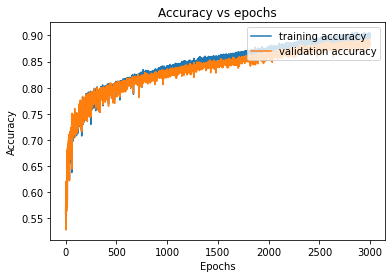

In [4]:
wandb.agent(sweep_id, run)